# ex_network_A


Design a 1D neural network of 1000 cells receiving 100 thalamic random inputs at 50, 55, 60, 65, 70 ms.

The thalamo-cx connectivity is one-to-one.

Model of cells is free of choice.

Record and plot spikes, voltage and both the conductances.

In [1]:
# fileName

fileName = 'ex_network_A'

In [2]:
# libs

import pyNN.nest as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt


/home/alberto-int/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'pynestkernel' does not match runtime version 3.7
  return f(*args, **kwds)


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/alberto-int/anaconda3/lib/python3.7/site-packages/PyNN-0.9.5-py3.7.egg/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


In [3]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 # [ms+]


/usr/lib/python3.5/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.


In [4]:
# make the network

structure = {}
structure['1D'] = space.Line(
                              dx=1.0, 
                              x0=0.0, 
                              y=0.0, 
                              z=0.0)

sizePop = 100
cx = {}
cx['tot'] = sim.Population(
                    sizePop,
                    sim.IF_cond_exp,
                    cellparams=sim.IF_cond_exp.default_parameters,
                    structure = structure['1D']
                   )



NEST does not allow setting an initial value for g_ex
NEST does not allow setting an initial value for g_in


In [5]:
# set recording of state variables

cx['tot'].record(['spikes','v','gsyn_exc','gsyn_inh'])   

/home/alberto-int/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:This function is deprecated. Please call randint(1, 100 + 1) instead


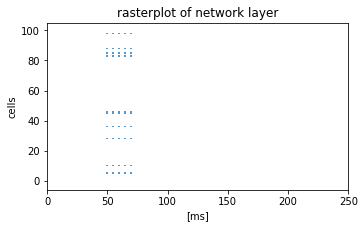

In [6]:
# make the thalamic input sources


spike_times = [[]] * sizePop
random_sources = np.random.random_integers(sizePop,size=int(sizePop/10))
for i in random_sources:
    spike_times[i] = [50, 55, 60, 65, 70]


    
fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['network']):
    axes_list[idx].eventplot(spike_times)
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)

In [7]:
thalamus = sim.Population(
                        sizePop,
                        sim.SpikeSourceArray(spike_times=spike_times),
                        structure=structure['1D']
                            )

In [8]:
# make the projection

In [9]:


projs = sim.Projection(
                        thalamus,
                        cx['tot'] ,
                        sim.OneToOneConnector(),
                        synapse_type=sim.StaticSynapse(weight=0.1, delay=1),
                        receptor_type='excitatory',
                        space = space.Space(axes = 'x'),
                        label='thal->cx-e'
                        )



In [10]:
# run simulation

sim.run(simtime) 

250.0

In [11]:
# save the results


outputs = {}

outputs['cx'] = cx['tot'].get_data()
for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
    cx['tot'].write_data(fileName + '_' + str(recording) + '.pkl')

In [12]:
# recover results function

def recover_results(outputs):
    results = {}
    for key in outputs.keys(): # to extract the name of the layer, e.g., Exc, Inh, Thalamus, etc  
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results


In [13]:
# recover results

results = recover_results(outputs)
results.keys()

gsyn_inh
gsyn_exc
v


dict_keys([('cx', 'gsyn_inh'), ('cx', 'gsyn_exc'), ('cx', 'v'), ('cx', 'spikes')])

(0, 250)

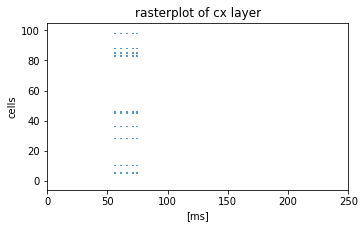

In [14]:
# check the spikes

fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)
axes_list = fig.axes
idx = 0
axes_list[idx].eventplot(results['cx', 'spikes'])
axes_list[idx].set_title('rasterplot of cx layer')
axes_list[idx].set_xlabel('[ms]')
axes_list[idx].set_ylabel('cells')
axes_list[idx].set_xlim(0, simtime)


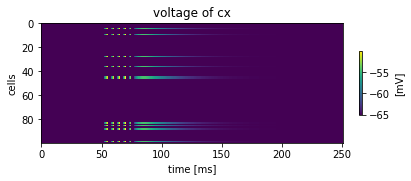

In [16]:
# check the voltage

fig, axes = plt.subplots(1, 1)#, figsize=(9,5))
fig.tight_layout(pad=4)
axes_list = fig.axes
idx = 0
im = axes_list[idx].imshow(results['cx', 'v'].T)
axes_list[idx].set_title('voltage of cx')
axes_list[idx].set_xlabel('time [ms]')
axes_list[idx].set_ylabel('cells')
fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')


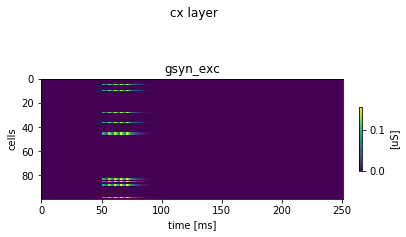

In [17]:
# check the conductances


for layer in ['cx']:
    fig, axes = plt.subplots(1, 1)
    fig.tight_layout(pad=4)
    fig.suptitle(str(layer) + ' layer')
    axes_list = fig.axes
    
    for idx, gsyn in enumerate(['gsyn_exc']):#, 'gsyn_inh']):
        im = axes_list[idx].imshow(results[layer, gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')

In [18]:
# end simulation

sim.end()